# Advanced scikit-learn

Authors: [Alexandre Gramfort](http://alexandre.gramfort.net), [Thomas Moreau](https://tommoral.github.io/about.html), and [Pedro L. C. Rodrigues](https://plcrodrigues.github.io/).

<img src="figures/sklearn-logo.png" width="150">

The aim of this notebook is:

  - To explain the **full scikit-learn API** (estimators, transformers, classifiers, regressors, splitters). 
      - A good reference is [here](https://scikit-learn.org/1.5/developers/develop.html) too.
  - To explain how to assemble these objects in complex **pipelines with mixed data types** (numerical, categorical, etc.) using `Pipeline` and `ColumnTransformer` objects.
  - Have you **write your own** transformer, splitter and classifier.
  
## Table of contents

* [1 Working only with numerical data](#workingnumerical)
    * [1.1 Pandas preprocessing](#workingnumerical_pandas)
    * [1.2 Making it less error prone using scikit-learn](#workingnumerical_errorprone)    
* [2 Working only with categorical data](#workingcategorical)
* [3 Combining both categorical and numerical data in the pipeline](#combining)
* [4 From one split to cross-validation](#crossvalidation)

To explain these concepts we will start from a full working code based on the Titanic dataset. 

Then, we will deconstruct all the blocks and start writing our own Python classes.

First, let's fetch the Titanic dataset directly from [OpenML](https://openml.org/).

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

In [2]:
X_df, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X_df.head()

/Users/aminerazig/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


The classification task is to predict whether or not a person will survive the Titanic disaster.

In [3]:
y

0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: survived, Length: 1309, dtype: category
Categories (2, object): ['0', '1']

We will split the data into a training and a testing set.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, random_state=42
)

<div class="alert alert-success">
    <p><b>QUESTIONS</b>:</p>
    <ul>
        <li>What would happen if you tried to fit a <tt>LogisticRegression</tt> classifier?</li>
    </ul>
</div>

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'Rekic, Mr. Tido'

# 1 Working only with numerical data <a class="anchor" id="workingnumerical"></a> [↑](#Table-of-contents)

Let's start with a model using only numerical columns.

In [7]:
X_df.dtypes

pclass        float64
name           object
sex          category
age           float64
sibsp         float64
parch         float64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

## 1.1 Pandas preprocessing  <a class="anchor" id="workingnumerical_pandas"></a> [↑](#Table-of-contents)

Before using scikit-learn, we will do some simple preprocessing using pandas. First, let's select only a few the numerical columns:

In [6]:
num_cols = ['pclass', 'age', 'parch', 'fare']

X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

<div class="alert alert-success">
    <p><b>QUESTIONS</b>:</p>
    <ul>
        <li>And now, what would happen if you tried to fit a <tt>LogisticRegression</tt> classifier ?</li>
    </ul>
</div>

In [19]:
model = LogisticRegression()
model.fit(X_train_num, y_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

We might want to look into a summary of the data that we try to fit.

In [8]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981 entries, 1139 to 1126
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  981 non-null    float64
 1   age     784 non-null    float64
 2   parch   981 non-null    float64
 3   fare    980 non-null    float64
dtypes: float64(4)
memory usage: 38.3 KB


Since there are some missing data, we can replace them with a mean.

In [9]:
X_train_num_imputed = X_train_num.fillna(X_train_num.mean())
X_train_num_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981 entries, 1139 to 1126
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  981 non-null    float64
 1   age     981 non-null    float64
 2   parch   981 non-null    float64
 3   fare    981 non-null    float64
dtypes: float64(4)
memory usage: 38.3 KB


In [20]:
model.fit(X_train_num_imputed, y_train)

LogisticRegression()

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
    <li>What should we do if there are also missing values in the test set?</li>
    <li>Process the test set so as to be able to compute the test score of the model.</li>
    </ul>
</div>

Solution is in `solutions/01-pandas_fillna_test.py`

In [ ]:
# TODO

## 1.2 Making it less error prone using scikit-learn <a class="anchor" id="workingnumerical_errorprone"></a> [↑](#Table-of-contents)

Scikit-learn provides several useful **transformers** to preprocess data. Its basic API is illustrated below:

<img src="figures/sklearn-transformers-api.png" width="450">

Basically, a transformed is used in three sequential steps:

1. Fit the transformer to the training data
2. Transform the training data
3. Transform the test data

Some examples of transformers are [scalers](https://scikit-learn.org/1.5/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling), [normalizers](https://scikit-learn.org/1.5/modules/preprocessing.html#normalization), and [categorical encoders](https://scikit-learn.org/1.5/modules/preprocessing.html#encoding-categorical-features). 

The `sklearn.impute.SimpleImputer` is a transformer allowing for the same job than the processing done with Pandas above. As we will see later, it integrates nicely with other scikit-learn components when using pipelines.

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")

As any estimator in scikit-learn, a transformer has a `fit` method which should be called on the training data to learn the required statistics. In the case of a mean imputer, we need to compute the mean for each feature.

In [11]:
imputer.fit(X_train_num)

SimpleImputer()

In [12]:
imputer.statistics_

array([ 2.29867482, 29.34768278,  0.39143731, 33.68646633])

To impute the values by the mean, we can use the `transform` method.

In [13]:
imputer.transform(X_train_num)

array([[ 3.    , 38.    ,  0.    ,  7.8958],
       [ 3.    ,  6.    ,  1.    , 15.2458],
       [ 1.    , 52.    ,  1.    , 79.65  ],
       ...,
       [ 3.    , 28.5   ,  0.    , 16.1   ],
       [ 3.    , 26.    ,  0.    ,  7.925 ],
       [ 3.    , 28.    ,  0.    ,  7.8958]])

As previoulsy mentioned, we should always use the values estimated using the training set in `fit` when imputing the test set. Otherwise, we risk suffering from overfitting due to [data leakage](https://scikit-learn.org/stable/common_pitfalls.html#data-leakage).

<div class="alert alert-warning">
<b>What is a "Transformer"?</b>: <br/>

Every transform in `sklearn` implements at least the following methods:

<ul>
    <li><tt>fit(X, y=None)</tt></li>
    <li><tt>transform(X)</tt></li>
    <li><tt>get_params()</tt></li>
    <li><tt>set_params(**kwargs)</tt></li>  
</ul>
</div>

In [14]:
params = imputer.get_params()
params

{'add_indicator': False,
 'copy': True,
 'fill_value': None,
 'keep_empty_features': False,
 'missing_values': nan,
 'strategy': 'mean'}

In [ ]:
imputer.fit?

In [ ]:
imputer.transform?

Let's look at the attributes of our `imputer`

In [21]:
public_attributes = [attr for attr in dir(imputer) if not attr.startswith('_')]
public_attributes

['add_indicator',
 'copy',
 'feature_names_in_',
 'fill_value',
 'fit',
 'fit_transform',
 'get_feature_names_out',
 'get_metadata_routing',
 'get_params',
 'indicator_',
 'inverse_transform',
 'keep_empty_features',
 'missing_values',
 'n_features_in_',
 'set_output',
 'set_params',
 'statistics_',
 'strategy',
 'transform']

We have among these attributes:

- **parameters** (keys in get_params method output)
- **methods** (fit, transform, etc.)
- **estimated quantities** that appear after a `fit` (ending with `_`)

In [22]:
public_methods = [
    attr for attr in dir(imputer)
    if not attr.startswith('_') and
    not attr.endswith('_') and
    attr not in params]
public_methods

['fit',
 'fit_transform',
 'get_feature_names_out',
 'get_metadata_routing',
 'get_params',
 'inverse_transform',
 'set_output',
 'set_params',
 'transform']

In [ ]:
imputer.inverse_transform?

Estimated quantities:

In [15]:
fit_attributes = [
    attr for attr in dir(imputer)
    if not attr.startswith('_') and
    attr.endswith('_')]
fit_attributes

['feature_names_in_', 'indicator_', 'n_features_in_', 'statistics_']

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>What are the attributes of a <tt>LogisticRegression</tt> classifier?. You will decompose these in the 3 categories.</li>
    </ul>
</div>

In [23]:
clf = LogisticRegression()
public_attributes = [attr for attr in dir(clf) if not attr.startswith('_')]
public_attributes

['C',
 'class_weight',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_metadata_routing',
 'get_params',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'score',
 'set_fit_request',
 'set_params',
 'set_score_request',
 'solver',
 'sparsify',
 'tol',
 'verbose',
 'warm_start']

### Using a Pipeline

We saw earlier that we should be careful when preprocessing data to avoid any "data leak" (i.e. reusing some knowledge from the training when testing our model). Scikit-learn provides the `Pipeline` class to make successive transformations. In addition, it will ensure that the right operations will be applied at the right time.

In [24]:
from sklearn import set_config

set_config(display='diagram')

In [25]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SimpleImputer(strategy='mean'),
                      LogisticRegression())
model.fit(X_train_num, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression())])

Alternative syntax using named "steps".

In [26]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("classifier", LogisticRegression())    
])
model.fit(X_train_num, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier', LogisticRegression())])

In [ ]:
model.score(X_test_num, y_test)

Saving your estimator in HTML for presentations, blog posts etc.

In [ ]:
from sklearn.utils import estimator_html_repr

with open('model.html', 'w') as fid:
    fid.write(estimator_html_repr(model))

# !open model.html

### Manipulating Pipeline steps

A pipeline is a sequence of `steps`. Each `step` is a scikit-learn estimator. All steps except the last one are typically **transformers** (i.e they have `fit`, `fit_transform`, `transform` methods) and the last step is a **classifier** or a **regressor**.

In [27]:
model.steps  # accessing steps as a list

[('imputer', SimpleImputer()), ('classifier', LogisticRegression())]

In [ ]:
model.named_steps  # accessing steps with their names as a dict

In [ ]:
model[:1]  # slicing a pipeline

In [ ]:
model[-1]

In [ ]:
from sklearn.base import is_classifier

is_classifier(model[-1])

For comparison, we can decompose the pipeline and chain the operations manually, mimicking what the `Pipeline` object does internally:

In [28]:
preprocessor = model[:-1]
classifier = model[-1]

X_train_preproc = preprocessor.fit_transform(X_train_num, y_train)
X_test_preproc = preprocessor.transform(X_test_num)

classifier.fit(X_train_preproc, y_train)
classifier.score(X_test_preproc, y_test)

0.6707317073170732

### Towards a ColumnTransformer

If we want to avoid creating `X_train_num` and fit the model on `X_train`, we can select the numerical columns using a `ColumnTransformer` object:

In [29]:
from sklearn.compose import ColumnTransformer

ColumnTransformer?

Init signature:
ColumnTransformer(
    transformers,
    *,
    remainder='drop',
    sparse_threshold=0.3,
    n_jobs=None,
    transformer_weights=None,
    verbose=False,
    verbose_feature_names_out=True,
)
Docstring:     
Applies transformers to columns of an array or pandas DataFrame.

This estimator allows different columns or column subsets of the input
to be transformed separately and the features generated by each transformer
will be concatenated to form a single feature space.
This is useful for heterogeneous or columnar data, to combine several
feature extraction mechanisms or transformations into a single transformer.

Read more in the :ref:`User Guide <column_transformer>`.

.. versionadded:: 0.20

Parameters
----------
transformers : list of tuples
    List of (name, transformer, columns) tuples specifying the
    transformer objects to be applied to subsets of the data.

    name : str
        Like in Pipeline and FeatureUnion, this allows the transformer and
        i

In [30]:
numerical_preprocessing = ColumnTransformer([
    ("imputer", SimpleImputer(strategy='mean'), num_cols)
])
    
model = Pipeline([
    ("numerical preproc.", numerical_preprocessing),
    ("classifier", LogisticRegression()),
])

model.fit(X_train, y_train)

Pipeline(steps=[('numerical preproc.',
                 ColumnTransformer(transformers=[('imputer', SimpleImputer(),
                                                  ['pclass', 'age', 'parch',
                                                   'fare'])])),
                ('classifier', LogisticRegression())])

In [31]:
model.score(X_test, y_test)

0.6707317073170732

# 2 Working only with categorical data <a class="anchor" id="workingcategorical"></a> [↑](#Table-of-contents)

Categorical columns are not supported natively by machine-learning algorithms and require a preprocessing step commonly called encoding. The most classical categorical encoders are the `OrdinalEncoder` and the `OneHotEncoder`, but many others exist and are implemented in `sklearn`; see [here](https://scikit-learn.org/dev/modules/preprocessing.html#encoding-categorical-features). 

Let's see what happens if we try to classify the data using only categorical features encoded via `OrdinalEncoder`.

In [32]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1139,3.0,"Rekic, Mr. Tido",male,38.0,0.0,0.0,349249,7.8958,NaN,S,NaN,NaN,NaN
678,3.0,"Boulos, Master. Akar",male,6.0,1.0,1.0,2678,15.2458,NaN,C,NaN,NaN,"Syria Kent, ON"
290,1.0,"Taussig, Mr. Emil",male,52.0,1.0,1.0,110413,79.6500,E67,S,NaN,NaN,"New York, NY"
285,1.0,"Straus, Mr. Isidor",male,67.0,1.0,0.0,PC 17483,221.7792,C55 C57,S,NaN,96.0,"New York, NY"
1157,3.0,"Rosblom, Mr. Viktor Richard",male,18.0,1.0,1.0,370129,20.2125,NaN,S,NaN,NaN,NaN


In [33]:
cat_cols = ['sex', 'embarked', 'pclass']

In [34]:
X_train_cat = X_train[cat_cols]

In [35]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981 entries, 1139 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sex       981 non-null    category
 1   embarked  980 non-null    category
 2   pclass    981 non-null    float64 
dtypes: category(2), float64(1)
memory usage: 17.5 KB


In [36]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
    ("ordinal_encoder", OrdinalEncoder())
])

categorical_preprocessing = ColumnTransformer([
    ("categorical_preproc", cat_pipeline, cat_cols)
])

model = Pipeline([
    ("categorical_preproc", categorical_preprocessing),
    ("classifier", LogisticRegression())
])
model.fit(X_train, y_train)

Pipeline(steps=[('categorical_preproc',
                 ColumnTransformer(transformers=[('categorical_preproc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'embarked',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

In [37]:
model.score(X_test, y_test)

0.7804878048780488

Remember that `Pipeline` is yet another scikit-learn estimator. It therefore has the methods `set_params` and `get_params` that can be inspected:

In [38]:
model.get_params()

{'memory': None,
 'steps': [('categorical_preproc',
   ColumnTransformer(transformers=[('categorical_preproc',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ordinal_encoder',
                                                     OrdinalEncoder())]),
                                    ['sex', 'embarked', 'pclass'])])),
  ('classifier', LogisticRegression())],
 'verbose': False,
 'categorical_preproc': ColumnTransformer(transformers=[('categorical_preproc',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value='missing',
                                                                 strategy='constant')),
                                                  ('

In [39]:
model.set_params(classifier__C=0.1)
model.get_params()

{'memory': None,
 'steps': [('categorical_preproc',
   ColumnTransformer(transformers=[('categorical_preproc',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ordinal_encoder',
                                                     OrdinalEncoder())]),
                                    ['sex', 'embarked', 'pclass'])])),
  ('classifier', LogisticRegression(C=0.1))],
 'verbose': False,
 'categorical_preproc': ColumnTransformer(transformers=[('categorical_preproc',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value='missing',
                                                                 strategy='constant')),
                                               

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    There exists, of course, many other strategies to encode categorical variables. In this exercise, you will write one by yourself that we shall call <tt>CountEncoder</tt>. The idea is to replace categorical variables with their count in the train set. When you've finished coding, change the ordinal encoder in the previous pipeline with an instance of your <tt>CountEncoder</tt> and see how the classification performance changes.
</div>

Your class will needs to inherit from `BaseEstimator`, `TransformerMixin` in `sklearn.base` submodule.

You will use the class `Counter` from the `collections` module in the Python standard library.

You will apply your code on this toy example

```python
>>> X = np.array([
...    [0, 2],
...    [1, 3],
...    [1, 1],
...    [1, 1],
... ])
>>> ce = CountEncoder()
>>> print(ce.fit_transform(X))
[[1 1]
 [3 1]
 [3 2]
 [3 2]]
```

Solution is in `solutions/01-count_encoder.py`.

# 3 Mix categorical and numerical data in a pipeline <a class="anchor" id="combining"></a> [↑](#Table-of-contents)

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
    <li>Try to combine the numerical and categorical pipelines into a single <tt>ColumnTransformer</tt></li>
        <li>Fit a <tt>LogisticRegression</tt> classifier on the output of this feature engineering. How does the test score evolve?</li>
    </ul>
</div>

Solution is in `solutions/01b-full_column_transformer.py`

In [42]:

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

cat_cols = ['sex', 'embarked', 'pclass']
num_cols = ['pclass', 'age', 'parch', 'fare']

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
    ("ordinal_encoder", OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ("categorical_preproc", cat_pipeline, cat_cols),
    ("numerical_preproc", SimpleImputer(), num_cols)

])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(max_depth=10, n_estimators=500))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_preproc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'embarked',
                                                   'pclass']),
                                                 ('numerical_preproc',
                                                  SimpleImputer(),
                                                  ['pclass', 'age', 'parch',
                                                   'fare'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=500))])

In [41]:
model.score(X_test, y_test)

0.7957317073170732

The procedure carried out so far was, until very recently, the standard way of handling tabular data mixing categorical and numerical values. Although this works well, it is not very straightforward and can require a great deal of expertise from the user. This was one of the main motivations behind the creation of [`skrub`](https://skrub-data.org/stable/index.html), a Python library that facilitates the preprocessing and feature engineering of tabular machine learning.

<img src="figures/skrub-logo.png" width="100">

One of the most important objects in `skrub` is the `TableVectorizer`, which automatically chooses which encoding strategy should be used for each column depending on its cardinality. See below what we get when using it as the first step in a `sklearn` pipeline:

In [44]:
from skrub import TableVectorizer

model = Pipeline([
    ("table_vectorizer", TableVectorizer()),
    ("imputer", SimpleImputer(strategy='mean')),
    ("classifier", LogisticRegression(solver='liblinear'))
])
model.fit(X_train, y_train)

Pipeline(steps=[('table_vectorizer', TableVectorizer()),
                ('imputer', SimpleImputer()),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [ ]:
print(model.score(X_test, y_test))

# 4 From one split to cross-validation <a class="anchor" id="crossvalidation"></a> [↑](#Table-of-contents)

Cross-validation objects are parametrized to split data in multiple train and test splits as described [here](https://scikit-learn.org/1.5/modules/cross_validation.html).

These objects are called **splitters** and consist of

- A `split` method that generate indices to partition data into training and test set.
- A `get_n_splits` method that returns the number of splitting iterations in the cross-validator

See [this](https://github.com/scikit-learn/scikit-learn/blob/6e9039160f0dfc3153643143af4cfdca941d2045/sklearn/model_selection/_split.py#L109) chunk of code for the structure of a basic splitter.

Given a `model`, some data `X, y` and a splitter one can fit and score on
all requested data splits. Some functions to do this automatically are `cross_val_score`
(historical way) and `cross_validate` (more modern way).

Let's first define a model:

In [45]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal_encoder", OrdinalEncoder())
])

categorical_preprocessing = ColumnTransformer([
    ("categorical_preproc", cat_pipeline, cat_cols)
])

model = Pipeline([
    ("categorical_preproc", categorical_preprocessing),
    ("classifier", LogisticRegression())
])
model

Pipeline(steps=[('categorical_preproc',
                 ColumnTransformer(transformers=[('categorical_preproc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'embarked',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

Let's now use a default 5-fold CV. You will see that there is a large amount of discrepancy among the test_score values

In [46]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X_df, y, cv=5)
pd.DataFrame(cv_results)

,fit_time,score_time,test_score
0,0.096210,0.011383,0.507634
1,0.023167,0.007315,0.809160
2,0.016112,0.004863,0.797710
3,0.016729,0.004721,0.709924
4,0.013850,0.005853,0.731801


In [47]:
pd.DataFrame(cv_results).agg(['mean', 'std'])

,fit_time,score_time,test_score
mean,0.033214,0.006827,0.711246
std,0.035386,0.002749,0.121393


The reason is that default CV object (here 5-fold CV) is deterministic, while the distribution of "survivor" is not uniform in the dataset. See:

<Axes: >

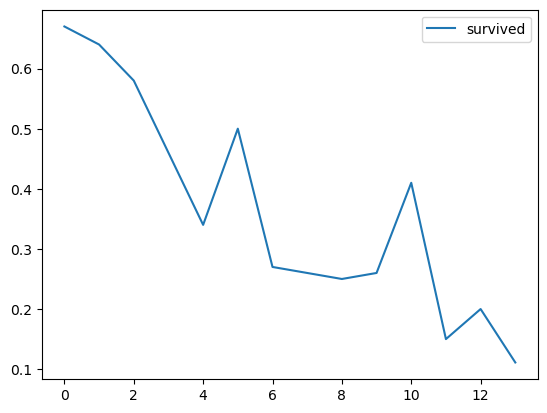

In [48]:
y.astype(int).to_frame().groupby(y.index.values // 100).mean().plot()

To fix this one needs stratified folds (so that the fraction of "survivors" is the same in each fold) but also to shuffle the data.

In [49]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(model, X_df, y, cv=cv)
pd.DataFrame(cv_results)

,fit_time,score_time,test_score
0,0.023620,0.010153,0.736641
1,0.023953,0.006453,0.790076
2,0.018619,0.007129,0.751908
3,0.020539,0.007207,0.790076
4,0.023191,0.005588,0.789272


In [50]:
pd.DataFrame(cv_results).agg(['mean', 'std'])

,fit_time,score_time,test_score
mean,0.021984,0.007306,0.771595
std,0.002314,0.001719,0.025519


The variance across folds is now much smaller which is great!

Let's look at the cross-validation scheme with a pretty plot:

/Users/aminerazig/Desktop/M2DS/DATA CAMP/datacamp-master/02_pipelines_and_column_transformers/plotting_utils.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/aminerazig/Desktop/M2DS/DATA CAMP/datacamp-master/02_pipelines_and_column_transformers/plotting_utils.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


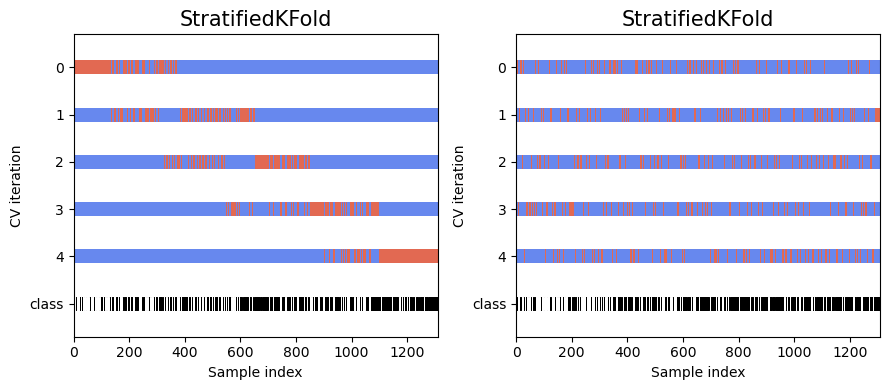

In [51]:
from plotting_utils import plot_cv_indices
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

for shuffle, ax in zip([False, True], axes):
    cv = StratifiedKFold(n_splits=5, shuffle=shuffle)
    plot_cv_indices(cv, X_df, y, ax=ax)

fig.tight_layout()

See [this page](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html) for more details and a list of the different cross-validation objects.

### Writing your own cross-validation object

As mentioned above, every splitter should implement a `split` and `get_n_splits` method. 

- `split` should return an iterable of tuples of indices. This is isually done using the concept of `yield` in Python for generators.
- `get_n_splits` returns an integer corresponding to the number of splits/folds chosen at the initialization of the splitter.

Let's first see what we get with the `cv` object defined before.

In [52]:
cv.get_n_splits()

5

In [53]:
for train_idx, test_idx in cv.split(X_df, y):
    print(train_idx[:5], test_idx[:5])
    print(f"N. samples train: {len(train_idx)}  -- N. samples test: {len(test_idx)}")

[0 1 2 3 4] [ 7  8 15 25 26]
N. samples train: 1047  -- N. samples test: 262
[0 2 3 5 6] [ 1  4 12 16 19]
N. samples train: 1047  -- N. samples test: 262
[0 1 2 4 5] [ 3 21 23 33 34]
N. samples train: 1047  -- N. samples test: 262
[0 1 3 4 5] [ 2 10 14 22 27]
N. samples train: 1047  -- N. samples test: 262
[1 2 3 4 7] [ 0  5  6  9 11]
N. samples train: 1048  -- N. samples test: 261


<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Imagine that the index of <code>y</code> gives you some provenance about the sample (e.g. which cohort of subjects in a clinical study). Write a splitter that allows to test the performance of a model on a left-out cohort. In other words, you will do as many splits as the number of unique values in <code>y.index.values</code>, and predict of each left-out cohort. To simulate this, we will modify the index variable <code>y</code>, just for educational purposes.
        </li>
    </ul>
</div>

Solution is in `solutions/01c-splitter.py`

In [ ]:
y_with_provenance = y.copy()
y_with_provenance.index = y_with_provenance.index.values // 200  # to easily mimic 5 cohorts
n_splits = y_with_provenance.index.nunique()
print(n_splits)

### When you're done with this notebook you can do the assignments on scikit-learn.